In [72]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from mpl_toolkits.basemap import Basemap

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import *
from BB_wx_calcs.wind import wind_uv_to_spd
from BB_basemap.draw_maps import draw_CONUS_HRRR_map
from BB_MesoWest.MesoWest_STNinfo import get_MW_location_dict
from BB_MesoWest.MesoWest_timeseries import get_mesowest_ts
from BB_MesoWest.MesoWest_nearesttime import get_mesowest_nearesttime
from BB_MesoWest.MesoWest_percentiles import get_mesowest_percentiles
from BB_data.grid_manager import pluck_point_new
from BB_wx_calcs.wind import wind_uv_to_spd

In [73]:
from matplotlib.dates import DateFormatter
formatter = DateFormatter('%b')

import matplotlib as mpl 
two_column = 5.5
one_column = 3.2
twothird_column = 6.8
mpl.rcParams['figure.figsize'] = [one_column, 2.8]
mpl.rcParams['figure.titlesize'] = 12
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.03
mpl.rcParams['figure.subplot.hspace'] = 0.00
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
    
mpl.rcParams['savefig.dpi'] = 1000    # 600 for print

| One Colulmn | 2/3 Page   | Two Columns   | More than 2 columns  |
|---|---|---|---|
| 3.2   | 4.5  | 5.5  | 6.5  |

In [74]:
# Load Lat/Lon Grid
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/'
latlon_file = h5py.File(DIR+'OSG_HRRR_latlon.h5', 'r')
lat = latlon_file['latitude'].value
lon = latlon_file['longitude'].value

In [75]:
DATE = datetime(2017, 10, 9, 6)
fxx = 0
stn = 'HWKC1'

var = 'UVGRD:10 m'

# MesoWest Station Info
LD = get_MW_location_dict(stn)
MWlat = LD[stn]['latitude']
MWlon = LD[stn]['longitude']

In [76]:
# Pluck point
point = pluck_point_new(MWlat, MWlon, lat, lon)
x = point[0][0]
y = point[1][0]

print lat[x,y], MWlat, 'and',lon[x,y], MWlon

38.73599 38.735086 and -122.83093 -122.837058


In [77]:
if var == 'TMP:2 m':
    ylabel = '2 m Temperature (C)'
elif var == 'DPT:2 m':
    ylabel = '2 m Dew Point (C)'
elif var == 'UVGRD:10 m':
    ylabel = r'10 m Wind Speed (m s$\mathregular{^{-1}}$)'
elif var == 'UVGRD:80 m':
    ylabel = r'80 m Wind Speed (m s$\mathregular{^{-1}}$)'
elif var == 'REFC:entire':
    ylabel = 'Simulated Composite Reflecivity (dBZ)'
elif var == 'HGT:500':
    ylabel = 'Geopotential Height (m)'

## Get OSG Percentiles for a Point

/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/UVGRD_10_m/OSG_HRRR_UVGRD_10_m_m10_d09_h06_f00.h5
Station: (99.999913961830742, 16.417688)


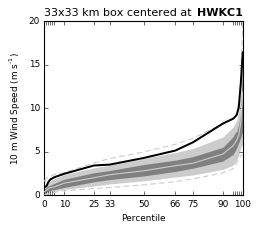

In [86]:
variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)
FILE = 'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % ((variable, DATE.month, DATE.day, DATE.hour))
print DIR+FILE

percentiles = [0,1,2,3,4,5,10,25,33,50,66,75,90,95,96,97,98,99,100]
box_radius = 5

with h5py.File(DIR+FILE, 'r') as ff:
    for i in percentiles:
        pp = ff["p%02d" % i][x-box_radius:x+box_radius+1,y-box_radius:y+box_radius+1]
        if i == 0:
            PP = pp
        else:
            PP = np.dstack([PP, pp])

## Convert Units
if var == 'TMP:2 m' or var == 'DPT:2 m':
    PP -= 273.15

## Clalculate area percentiles for each percentile from the OSG percentiles
for i, percentile in enumerate(percentiles):
    p = np.percentile(PP[:,:,i], [0, 1, 2, 3, 4, 5, 25, 50, 75, 95, 96, 97, 98, 99, 100])
    if i == 0:
        area_P = p
    else:
        area_P = np.dstack([area_P, p])

## HRRR Model Run date
RUN = DATE-timedelta(hours=fxx)

## Get HRRR data for this run
if var.split(':')[0] == 'UVGRD':
    # Calculate wind speed from U and V components
    level = var.split(':')[1]
    HU = get_hrrr_variable(RUN, 'UGRD:'+level, fxx=fxx, value_only=True, verbose=False)    
    HV = get_hrrr_variable(RUN, 'VGRD:'+level, fxx=fxx, value_only=True, verbose=False)
    speed = wind_uv_to_spd(HU['value'], HV['value'])
    H = HU.copy()
    H['value'] = speed
else:
    H = get_hrrr_variable(RUN, var, fxx=f, verbose=False)


## Convert units and get values in bounding box area
if var == 'TMP:2 m' or var == 'DPT:2 m':
    Hpoint = H['value'][x,y]-273.15
    Harea = H['value'][x-box_radius:x+box_radius+1,y-box_radius:y+box_radius+1]-273.15    
else:
    Hpoint = H['value'][x,y]
    Harea = H['value'][x-box_radius:x+box_radius+1,y-box_radius:y+box_radius+1]


## --- Plot OSG percentiles ---------------------------------------
plt.fill_between(percentiles, area_P[0][5], area_P[0][-6],
                 label='p05-p95',
                 facecolor=[.8, .8, .8],
                 linewidth=0,
                 zorder=1)
plt.fill_between(percentiles, area_P[0][6], area_P[0][-7],
                 facecolor=[.5, .5, .5],
                 linewidth=0,
                 label='p25-p75',
                 zorder=1)

plt.plot(percentiles, area_P[0][7],
         color=[.8, .8, .8],
         linewidth=1,
         zorder=10)

for per in [0, -1]:
    plt.plot(percentiles, area_P[0][per],
             color=[.8, .8, .8],
             linestyle='--', dashes=(5,3),
             linewidth=1,
             zorder=10)

## Plot OSG percentiles for the single grid box nearest the station of interest
plt.plot(percentiles, PP[box_radius,box_radius,:],
         color='k',
         label='%s OSG Percentiles' % stn,
         zorder=100)



## Plot value from current HRRR run for every grid box
#for i in range(box_radius*2+1):
#    for j in range(box_radius*2+1):
#        plt.axhline(Harea[i,j], linewidth=.1)

## Plot HRRR value for stn grid box for urrent HRRR run
# Linear interpolation to find the percentile for the value
stnPP = PP[box_radius,box_radius,:]
if Hpoint > np.max(stnPP):
    Y = Hpoint
    X = 100
    print "station Hpoint > PP, exceeds p100", D, f
elif Hpoint < np.min(stnPP):
    Y = Hpoint
    X = 0
    print "station Hpoint < PP, exceeds p00", D, f
else:
    y1 = np.min(filter(lambda x: x>=Hpoint, stnPP))
    y1_idx = np.where(stnPP==y1)[0][0]
    x1 = percentiles[y1_idx]
    y2 = stnPP[y1_idx-1]
    x2 = percentiles[y1_idx-1]
    m = (y2-y1)/(x2-x1)
    b = 0-m*x1+y1
    Y = Hpoint
    X = (Y-b)/m
    print 'Station:', (X, Y)


## --- Other Plot Elements --------------------------------------
plt.title('%sx%s km box centered at' % (np.shape(PP)[0]*3, np.shape(PP)[0]*3), loc='left')
plt.title('%s' % (stn), fontweight='semibold', loc='right')
tick_labels = [0,'','','','','', 10, 25, 33, 50, 66, 75, 90, '', '', '', '','',100]
plt.xticks(percentiles, tick_labels)
plt.xlim([0,100])
plt.ylabel(ylabel)
plt.xlabel('Percentile')

plt.savefig('./figs/area_percentiles_%s' % stn)

In [83]:
LATS_BOX = lat[x-box_radius:x+box_radius+1,y-box_radius:y+box_radius+1]
LONS_BOX = lon[x-box_radius:x+box_radius+1,y-box_radius:y+box_radius+1]

top_right_lat = LATS_BOX.max()
top_right_lon = LONS_BOX.min()

bot_left_lat = LATS_BOX.min()
bot_left_lon = LONS_BOX.max()

print bot_left_lon, top_right_lon
print bot_left_lat, top_right_lat

m = Basemap(llcrnrlon=MWlon-.3,  urcrnrlon=MWlon+.3,
            llcrnrlat=MWlat-.3, urcrnrlat=MWlat+.3)

-122.61779 -123.04462
38.56945 38.9024


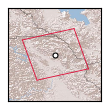

In [85]:
plt.figure(figsize=[1.5, 1.5])
m.drawcounties()
m.arcgisimage(service='World_Shaded_Relief', dpi=1000)

#m.pcolormesh(LONS_BOX, LATS_BOX, np.ones_like(LONS_BOX), alpha=.4)
m.scatter(MWlon, MWlat, color='white', edgecolor='k')

# Bottom Boundary
m.drawgreatcircle(LONS_BOX[0,-1], LATS_BOX[0,-1],
                  LONS_BOX[0,0], LATS_BOX[0,0],
                  color='crimson',
                  linewidth=.8)

# Left Boundary
m.drawgreatcircle(LONS_BOX[0,0], LATS_BOX[0,0],
                  LONS_BOX[-1,0], LATS_BOX[-1,0],
                  color='crimson',
                  linewidth=.8)

# Top Boundary
m.drawgreatcircle(LONS_BOX[-1,-1], LATS_BOX[-1,-1],
                  LONS_BOX[-1,0], LATS_BOX[-1,0],
                  color='crimson',
                  linewidth=.8)

# Right Boundary
m.drawgreatcircle(LONS_BOX[-1,-1], LATS_BOX[-1,-1],
                  LONS_BOX[0,-1], LATS_BOX[0,-1],
                  color='crimson',
                  linewidth=.8)

plt.savefig('./figs/area_percentiles_%s_map' % stn, transparent=True)